<a href="https://colab.research.google.com/github/rik03/CarDekho-Analysis/blob/main/Copy_of_CarDekho_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis on CarDekho Dataset

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import os

In [4]:
import re

In [5]:
from datetime import date

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('drive/MyDrive/ML Projects/CarDekho-Analysis/Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [7]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In this dataset we look to predict the selling_price based on the various measures and factors provided. We will try to fit a model which helps us to do the same.

In [8]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [9]:
df=df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7906 non-null   object 
 1   year           7906 non-null   int64  
 2   selling_price  7906 non-null   int64  
 3   km_driven      7906 non-null   int64  
 4   fuel           7906 non-null   object 
 5   seller_type    7906 non-null   object 
 6   transmission   7906 non-null   object 
 7   owner          7906 non-null   object 
 8   mileage        7906 non-null   object 
 9   engine         7906 non-null   object 
 10  max_power      7906 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7906 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 864.7+ KB


In [11]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
8123    False
8124    False
8125    False
8126     True
8127     True
Length: 7906, dtype: bool


In [12]:
df = df.drop_duplicates()

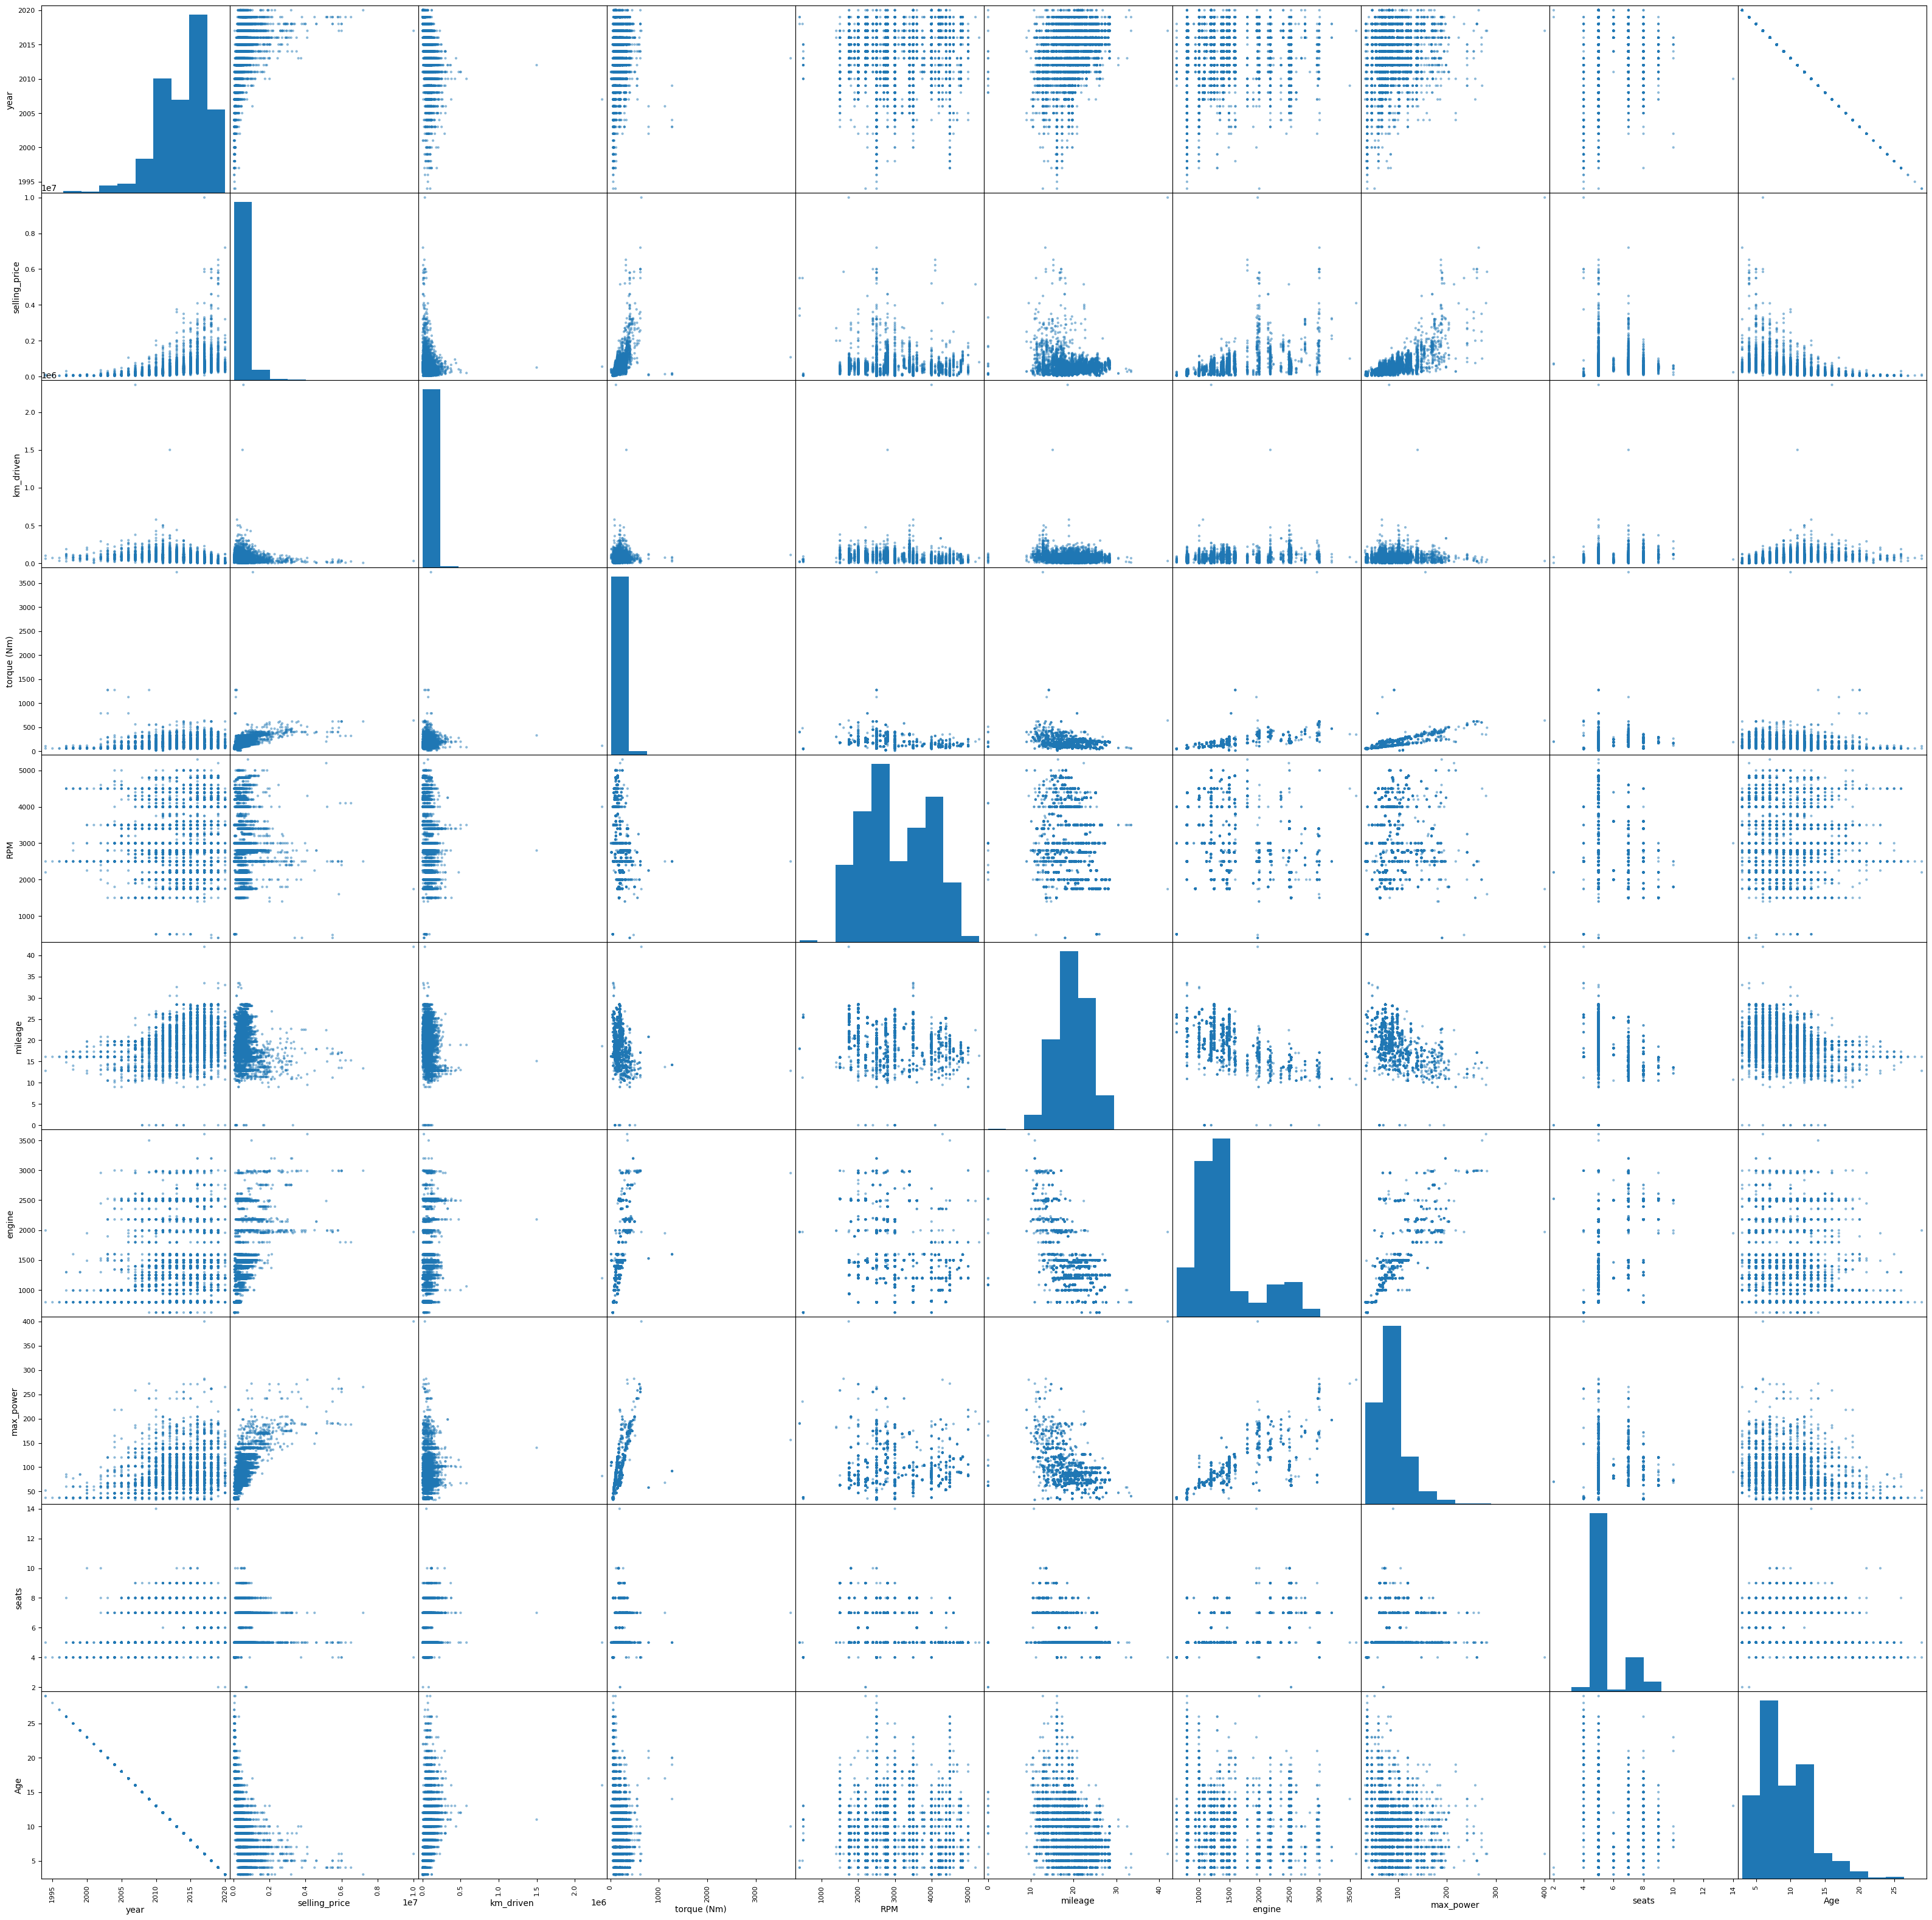

In [33]:
pd.plotting.scatter_matrix(df, figsize=(40,40));

### Data Preprocessing
In this stage we are cleaning the data and extracting features which could be useful from initial inspection.

Year and selling price show an interesting pattern, have to look more into it. Also selling price and seats show a pattern as well.

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,6392.0,2013.893773,3.742303,1994.0,2012.0,2014.00,2017.0,2020.0
selling_price,6392.0,542057.989049,529399.521876,29999.0,270000.0,438999.00,650000.0,10000000.0
km_driven,6392.0,71899.854036,58982.067300,1.0,35000.0,65000.00,100000.0,2360457.0
torque (Nm),6392.0,172.959260,100.905981,14.9,110.0,170.00,200.0,3724.0
RPM,6392.0,3036.010325,900.846538,400.0,2250.0,3000.00,4000.0,5300.0
mileage,6392.0,19.640186,4.046577,0.0,17.0,19.70,22.7,42.0
engine,6392.0,1426.544587,498.176125,624.0,1196.0,1248.00,1498.0,3604.0
max_power,6392.0,87.846151,31.904397,32.8,67.1,81.86,100.0,400.0
seats,6392.0,5.441489,0.980654,2.0,5.0,5.00,5.0,14.0
Age,6392.0,9.106227,3.742303,3.0,6.0,9.00,11.0,29.0


From this summary, we can see the minimum mileage is 0, which is not possible. So there must be some issue with this data. And also the minimum selling price of a car is 30k which is weird.

In [15]:
df.fuel = pd.Series(df.fuel, dtype='category')
df.seller_type = pd.Series(df.seller_type, dtype='category')
df.transmission	=pd.Series(df.transmission, dtype='category')
df.owner	= pd.Series(df.owner, dtype='category')
df.fuel.dtype
df.seller_type.dtype
df.transmission.dtype
df.owner.dtype

CategoricalDtype(categories=['First Owner', 'Fourth & Above Owner', 'Second Owner',
                  'Test Drive Car', 'Third Owner'],
, ordered=False)

In [16]:
df['fuel'].unique()

['Diesel', 'Petrol', 'LPG', 'CNG']
Categories (4, object): ['CNG', 'Diesel', 'LPG', 'Petrol']

In [ ]:
df.head()

In [17]:
df['mileage'] =  df['mileage'].str.extract('(\d+\.\d+)').astype(float)
df['engine'] =  df['engine'].str.extract('(\d+)').astype(int)
df['max_power'] =  df['max_power'].str.extract('(\d+.*\d+)').astype(float)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [18]:
'''def calculateTorque(torque):
  torque = torque.apply(lambda x: re.split(r'\s|\(|\)|@|[NrknRK]|-|\\|~|\+|/',x.replace(',','')))
  torque = torque.apply(pattern(torque))
  return torque
def pattern(x):
  mult = 9.8 if 'gm' in x else 1
  num=[]
  for i in range(len(x)):
    if x[i].isnumeric():
      num.append(float(x[i]))
  num = num.sort(reverse=True)
  val = min(num) * mult
  t = val/(sum(num.pop())/len(num.pop()))
  return t'''

torqueData =  df['torque'].tolist()
i=0
newData=[]
newTorque=[]
newRpm=[]
for x in torqueData:
  i = i+1
  mult = 9.8 if 'gm' in x else 1
  newlist = re.findall("\d+[.,]*\d*", x)
  convertedTorque = float(newlist[0]) * mult
  newlist[0] = str(convertedTorque)
  newTorque.append(newlist[0])
  newRpm.append(newlist[-1])
  newData.append(newlist)
df.insert(8, "torque (Nm)", newTorque, True)
df.insert(9, "RPM", newRpm, True)

In [30]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.00,2000.0,23.40,1248,74.00,5.0,Maruti,Swift Dzire VDI,9
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.00,2500.0,21.14,1498,103.52,5.0,Skoda,Rapid 1.5 TDI Ambition,9
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750.0,23.00,1396,90.00,5.0,Hyundai,i20 Sportz Diesel,13
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,113.75,4000.0,20.14,1197,81.86,5.0,Hyundai,Xcent 1.2 VTVT E Plus,6
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,59.00,2500.0,16.10,796,37.00,4.0,Maruti,800 DX BSII,22


In [20]:
df.drop('torque',inplace=True,axis=1)

In [21]:
df['torque (Nm)'] = pd.to_numeric(df['torque (Nm)'])
df['RPM'] = pd.to_numeric(df['RPM'],errors='coerce')
df.dropna(inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 0 to 8125
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           6392 non-null   object  
 1   year           6392 non-null   int64   
 2   selling_price  6392 non-null   int64   
 3   km_driven      6392 non-null   int64   
 4   fuel           6392 non-null   category
 5   seller_type    6392 non-null   category
 6   transmission   6392 non-null   category
 7   owner          6392 non-null   category
 8   torque (Nm)    6392 non-null   float64 
 9   RPM            6392 non-null   float64 
 10  mileage        6392 non-null   float64 
 11  engine         6392 non-null   int64   
 12  max_power      6392 non-null   float64 
 13  seats          6392 non-null   float64 
dtypes: category(4), float64(5), int64(4), object(1)
memory usage: 574.9+ KB


In [24]:
def extractBrand(x):
  lb = str(x).split()
  return lb[0]
df['Brand'] = df['name'].apply(extractBrand)

In [25]:
len(df.name.unique())

1834

In [26]:
len(df.Brand.unique())

31

In [27]:
def extractModel(x):
  lb = str(x).split()
  model = " ".join(lb[1:])
  return model
df['Model'] = df['name'].apply(extractModel)

In [28]:
df[['name','Brand','Model']]

,name,Brand,Model
0,Maruti Swift Dzire VDI,Maruti,Swift Dzire VDI
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid 1.5 TDI Ambition
3,Hyundai i20 Sportz Diesel,Hyundai,i20 Sportz Diesel
5,Hyundai Xcent 1.2 VTVT E Plus,Hyundai,Xcent 1.2 VTVT E Plus
7,Maruti 800 DX BSII,Maruti,800 DX BSII
...,...,...,...
8120,Hyundai Santro Xing GLS,Hyundai,Santro Xing GLS
8121,Maruti Wagon R VXI BS IV with ABS,Maruti,Wagon R VXI BS IV with ABS
8122,Hyundai i20 Magna 1.4 CRDi,Hyundai,i20 Magna 1.4 CRDi
8123,Hyundai i20 Magna,Hyundai,i20 Magna


In [29]:
df['Age']=date.today().year-df['year']
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque (Nm),RPM,mileage,engine,max_power,seats,Brand,Model,Age
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190.00,2000.0,23.40,1248,74.00,5.0,Maruti,Swift Dzire VDI,9
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250.00,2500.0,21.14,1498,103.52,5.0,Skoda,Rapid 1.5 TDI Ambition,9
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,219.52,2750.0,23.00,1396,90.00,5.0,Hyundai,i20 Sportz Diesel,13
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,113.75,4000.0,20.14,1197,81.86,5.0,Hyundai,Xcent 1.2 VTVT E Plus,6
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,59.00,2500.0,16.10,796,37.00,4.0,Maruti,800 DX BSII,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8120,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,96.10,3000.0,17.92,1086,62.10,5.0,Hyundai,Santro Xing GLS,15
8121,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,90.00,3500.0,18.90,998,67.10,5.0,Maruti,Wagon R VXI BS IV with ABS,10
8122,Hyundai i20 Magna 1.4 CRDi,2014,475000,80000,Diesel,Individual,Manual,Second Owner,219.70,2750.0,22.54,1396,88.73,5.0,Hyundai,i20 Magna 1.4 CRDi,9
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,113.70,4000.0,18.50,1197,82.85,5.0,Hyundai,i20 Magna,10


### Exploratory Data Analysis
Here we visually explore the data and try to find useful relations

Text(0.5, 1.0, 'Top 10 Car brands for sale')

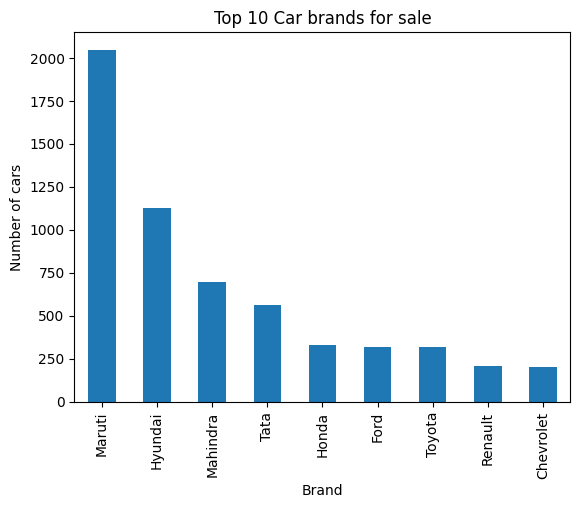

In [ ]:
df.groupby('Brand').count().name.sort_values(ascending=False)[0:9].plot.bar()
plt.ylabel('Number of cars')
plt.title("Top 10 Car brands for sale")

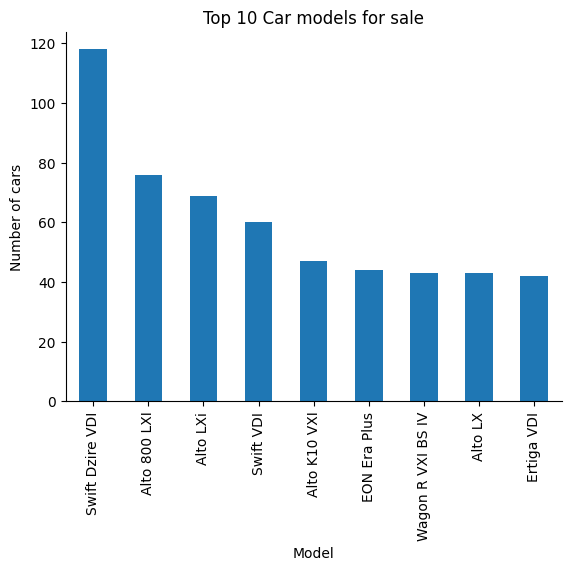

In [81]:
df.groupby('Model').count().name.sort_values(ascending=False)[0:9].plot.bar()
plt.ylabel('Number of cars')
plt.title("Top 10 Car models for sale")
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-79-11fa798df926>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Brand').mean().selling_price.sort_values(ascending=True)[-9:].plot.barh()


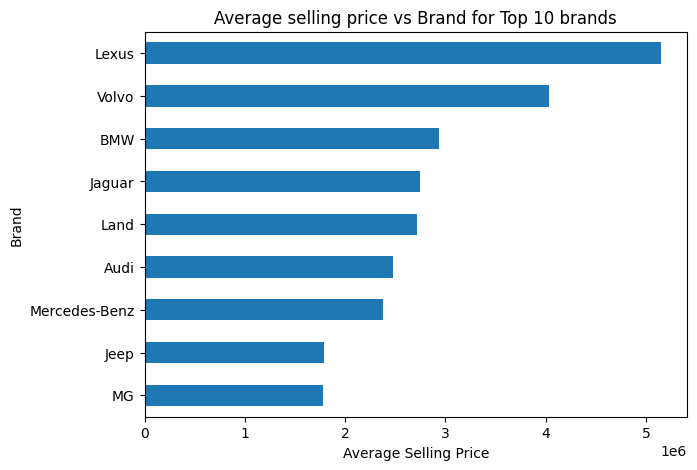

In [79]:
plt.figure(figsize=(7,5))
df.groupby('Brand').mean().selling_price.sort_values(ascending=True)[-9:].plot.barh()
plt.xlabel('Average Selling Price')
plt.title('Average selling price vs Brand for Top 10 brands');

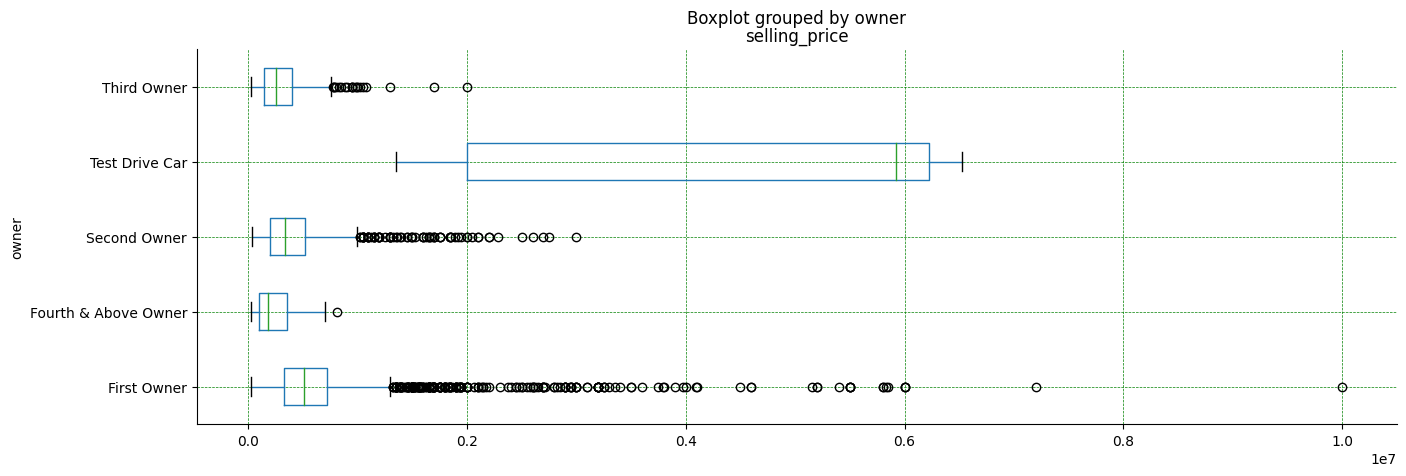

In [82]:
fig, ax = plt.subplots(figsize=(15, 5))
df.boxplot('selling_price', by='owner', ax=ax, vert=0);
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

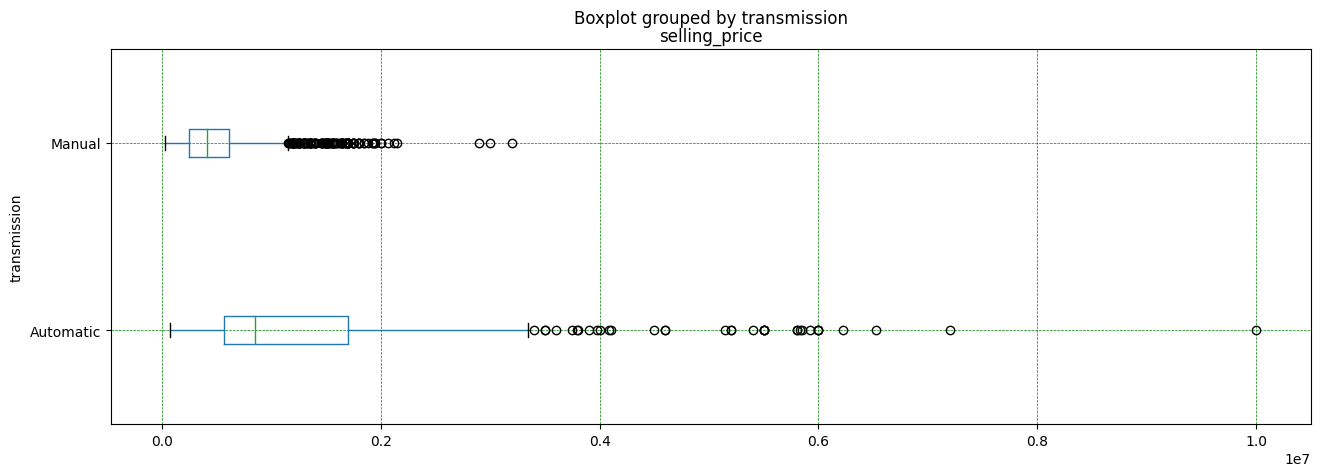

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))
df.boxplot('selling_price', by='transmission', ax=ax, vert=0);
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

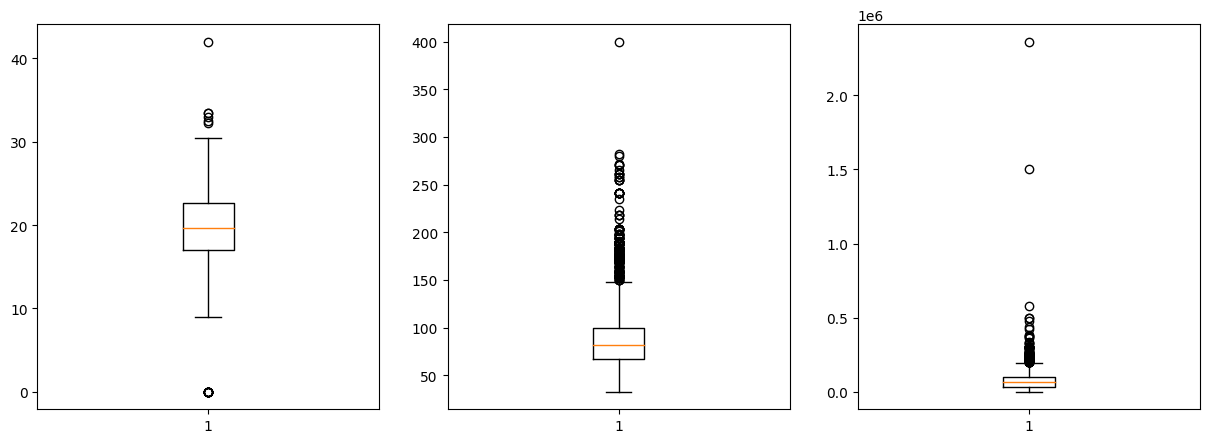

In [88]:
fig, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].boxplot(df.mileage.to_list());
ax[1].boxplot(df.max_power.to_list());
ax[2].boxplot(df.km_driven.to_list());

<Axes: xlabel='seller_type'>

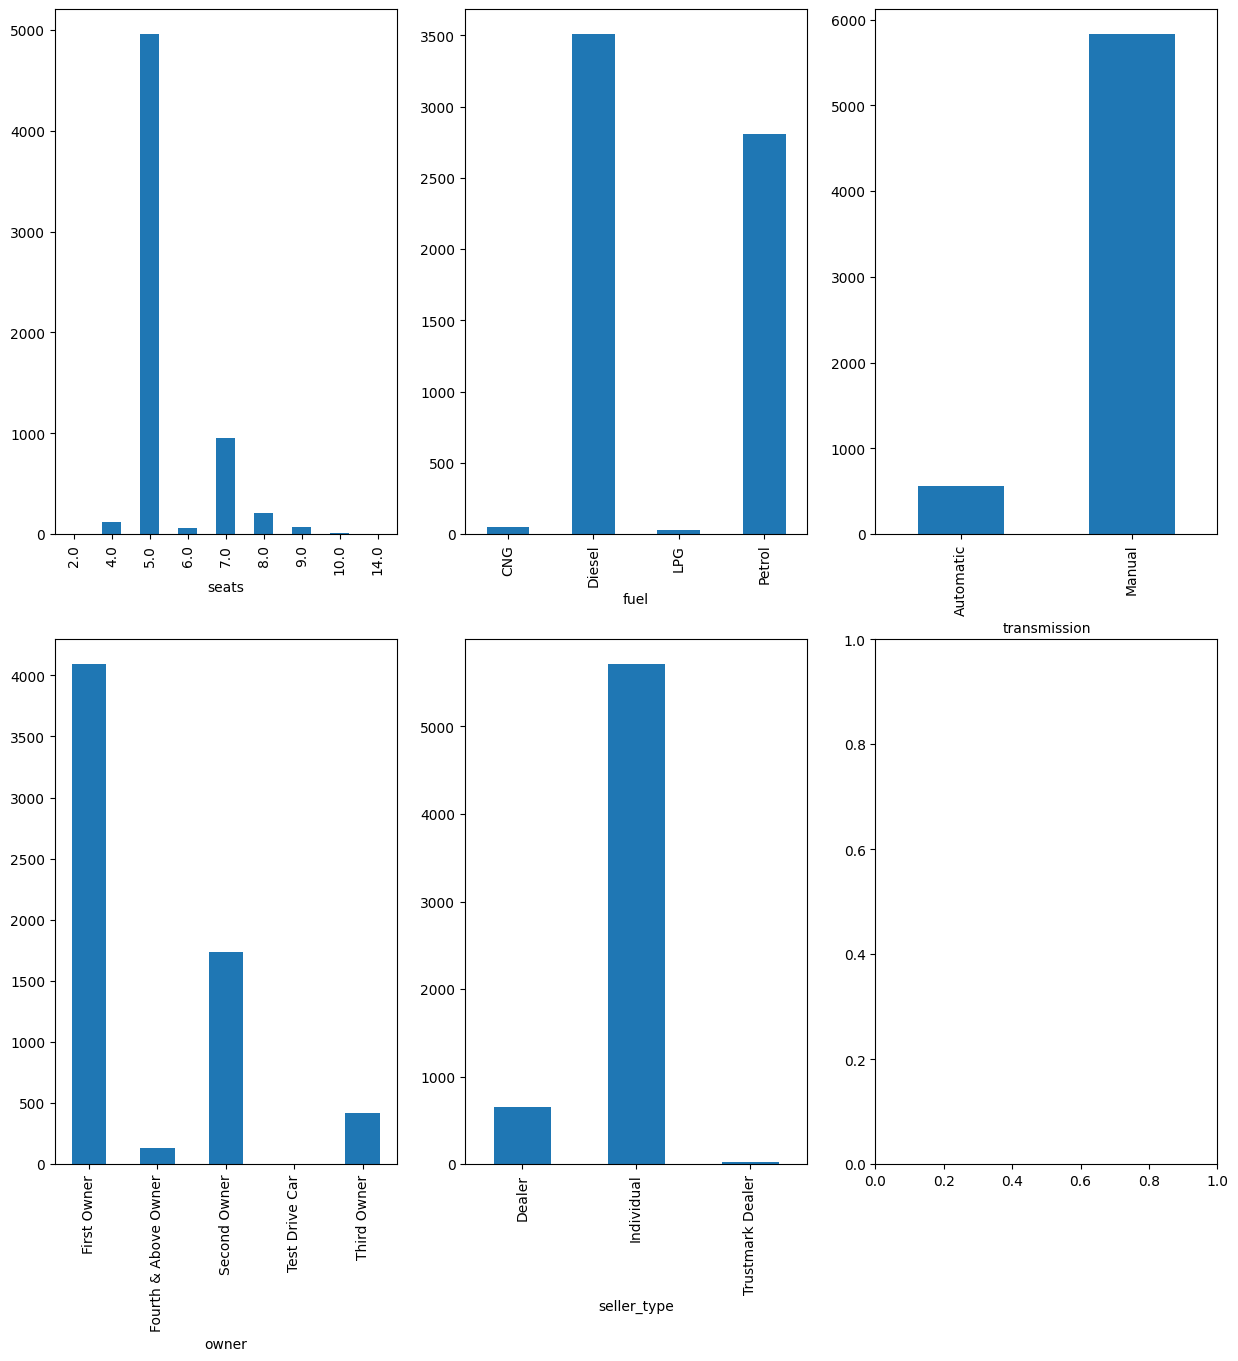

In [106]:
fig, ax = plt.subplots(2,3,figsize=(15, 15))
df.groupby('seats').count().name.plot.bar(ax=ax[0,0])
df.groupby('fuel').count().name.plot.bar(ax=ax[0,1])
df.groupby('transmission').count().name.plot.bar(ax=ax[0,2])
df.groupby('owner').count().name.plot.bar(ax=ax[1,0])
df.groupby('seller_type').count().name.plot.bar(ax=ax[1,1])

<ipython-input-58-cb89674ad4e6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='viridis')


<Axes: >

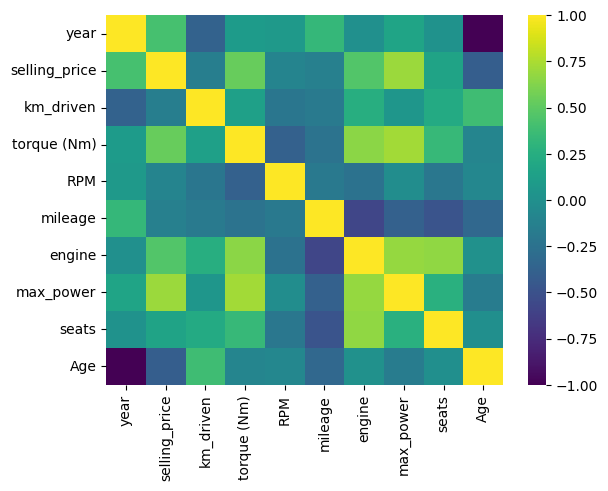

In [58]:
sns.heatmap(df.corr(),cmap='viridis')

In [60]:
df.corr()

<ipython-input-60-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,year,selling_price,km_driven,torque (Nm),RPM,mileage,engine,max_power,seats,Age
year,1.000000,0.410411,-0.377689,0.088047,0.070317,0.330476,-0.004494,0.170308,0.015297,-1.000000
selling_price,0.410411,1.000000,-0.149597,0.531739,-0.099345,-0.138352,0.454774,0.702614,0.159814,-0.410411
km_driven,-0.377689,-0.149597,1.000000,0.132789,-0.217085,-0.184953,0.251484,0.046923,0.215658,0.377689
torque (Nm),0.088047,0.531739,0.132789,1.000000,-0.383475,-0.239080,0.652871,0.719185,0.343485,-0.088047
RPM,0.070317,-0.099345,-0.217085,-0.383475,1.000000,-0.192152,-0.247809,-0.026529,-0.203715,-0.070317
mileage,0.330476,-0.138352,-0.184953,-0.239080,-0.192152,1.000000,-0.585385,-0.388170,-0.481286,-0.330476
engine,-0.004494,0.454774,0.251484,0.652871,-0.247809,-0.585385,1.000000,0.686993,0.664654,0.004494
max_power,0.170308,0.702614,0.046923,0.719185,-0.026529,-0.388170,0.686993,1.000000,0.269684,-0.170308
seats,0.015297,0.159814,0.215658,0.343485,-0.203715,-0.481286,0.664654,0.269684,1.000000,-0.015297
Age,-1.000000,-0.410411,0.377689,-0.088047,-0.070317,-0.330476,0.004494,-0.170308,-0.015297,1.000000


In [61]:
df.corr().selling_price

<ipython-input-61-67a5a54cf195>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().selling_price


year             0.410411
selling_price    1.000000
km_driven       -0.149597
torque (Nm)      0.531739
RPM             -0.099345
mileage         -0.138352
engine           0.454774
max_power        0.702614
seats            0.159814
Age             -0.410411
Name: selling_price, dtype: float64

In [ ]:
df = pd.concat([df.drop('fuel',axis=1),pd.get_dummies(df.fuel)],axis=1)
df = pd.concat([df.drop('seller_type',axis=1),pd.get_dummies(df.seller_type)],axis=1)
df = pd.concat([df.drop('transmission',axis=1),pd.get_dummies(df.transmission)],axis=1)
df = pd.concat([df.drop('owner',axis=1),pd.get_dummies(df.owner)],axis=1)

In [ ]:
renamed_columns = {'First Owner': 'first_own',
                   'Fourth & Above Owner': 'fourth_own',
                   'Second Owner': 'second_own',
                   'Test Drive Car':'test_drive_car',
                   'Third Owner': 'third_own',
                   'torque (Nm)':'torque(Nm)'
                   }
df.rename(columns=renamed_columns,inplace=True)
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'mileage', 'engine',
       'max_power', 'torque(Nm)', 'RPM', 'seats', 'CNG', 'Diesel', 'LPG',
       'Petrol', 'Dealer', 'Individual', 'Trustmark Dealer', 'Automatic',
       'Manual', 'first_own', 'fourth_own', 'second_own', 'test_drive_car',
       'third_own', 'Brand'],
      dtype='object')

In [ ]:
# from sklearn.preprocessing import StandardScaler
# obj = StandardScaler()
# df_n = obj.fit_transform(df.drop(['name','Brand'],axis=1))
# df_n

In [ ]:
# Finding relation with customer type

m_cust = ols('selling_price ~ first_own + second_own ',data=df).fit()
print(m_cust.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     158.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           7.55e-68
Time:                        10:34:53   Log-Likelihood:                -93158.
No. Observations:                6392   AIC:                         1.863e+05
Df Residuals:                    6389   BIC:                         1.863e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.296e+05   2.18e+04     15.104      0.0

In [ ]:
m_cust = ols('selling_price ~ first_own + second_own + third_own',data=df).fit()
print(m_cust.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     106.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           3.31e-67
Time:                        10:35:18   Log-Likelihood:                -93157.
No. Observations:                6392   AIC:                         1.863e+05
Df Residuals:                    6388   BIC:                         1.863e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.878e+05   4.37e+04      8.879      0.0

In [ ]:
m_cust = ols('selling_price ~ first_own + third_own',data=df).fit()
print(m_cust.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     159.5
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.64e-68
Time:                        10:38:50   Log-Likelihood:                -93157.
No. Observations:                6392   AIC:                         1.863e+05
Df Residuals:                    6389   BIC:                         1.863e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.094e+05   1.19e+04     34.351      0.0

**Interpretation:**

Here we see that for the first model with only the first_own and second_own, we see both of them to be significant.We proceed to add third_own to that model and
find that both third_own and second_own becomes insignificant in the presence of first_own. Also adding the third_own doesn't increase the $R^2$ value by much. But we need to see that while adding more variables as the correlation doesn't makes sense.Maybe it would be better to standardize the data for proper interpretation.

In [ ]:
# Checking for the significance of fuel type
m_fuel = ols('selling_price ~ Petrol + LPG + Diesel',data=df).fit()
print(m_fuel.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     151.5
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           7.46e-95
Time:                        10:34:09   Log-Likelihood:                -93093.
No. Observations:                6392   AIC:                         1.862e+05
Df Residuals:                    6388   BIC:                         1.862e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.216e+05   7.24e+04      4.445      0.0

In [ ]:
m_fuel = ols('selling_price ~ Petrol + LPG',data=df).fit()
print(m_fuel.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     215.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           2.90e-91
Time:                        10:34:10   Log-Likelihood:                -93104.
No. Observations:                6392   AIC:                         1.862e+05
Df Residuals:                    6389   BIC:                         1.862e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.604e+05   8591.672     76.868      0.0

**Interpretation** :

Here we see that when we take only three of the fuel types we see they all are insignificant in the presence of other, but when we take all four of them we see a increse in the p values of all of them. We see them become insignificant because we know that,

CNG + LPG + Petrol + Diesel = 1(always).

Also we see that they are negatively correlated with the price.